In [1]:
SK_CASES_BY_DAY =   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,0,3,11,11,12,17,11,25,8,19,14,41]
INTERVENTION_DAYS = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1, 1, 1, 0, 0, 0, 0,0, 0, 0, 0]

In [2]:
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/home/usamec/anaconda3/envs/covid/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [13]:
import pymc3 as pm
import numpy as np
import theano
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [4]:
# optimization should be o3 here, otherwise things will get slow
# use 
# export THEANO_FLAGS='optimizer=o3'
print(theano.config)

floatX (('float64', 'float32', 'float16')) 
    Doc:  Default floating-point precision for python casts.

Note: float16 support is experimental, use at your own risk.
    Value:  float64

warn_float64 (('ignore', 'warn', 'raise', 'pdb')) 
    Doc:  Do an action when a tensor variable with float64 dtype is created. They can't be run on the GPU with the current(old) gpu back-end and are slow with gamer GPUs.
    Value:  ignore

pickle_test_value (<function BoolParam.<locals>.booltype at 0x7fa30d3312f0>) 
    Doc:  Dump test values while pickling model. If True, test values will be dumped with model.
    Value:  True

cast_policy (('custom', 'numpy+floatX')) 
    Doc:  Rules for implicit type casting
    Value:  custom

int_division (('int', 'raise', 'floatX')) 
    Doc:  What to do when one computes x / y, where both x and y are of integer types
    Value:  int

deterministic (('default', 'more')) 
    Doc:  If `more`, sometimes we will select some implementation that are more determinis

In [5]:
def run_simul(cases, interventions, intervention_alpha=3, import_mean=5, import_std=5, beta_std_factor=2, obs_kernel=[0,0,0,0,1,2,3,4,5,4,3,2,1]):
    """
    cases - number of reported cases for each day 
    intervetions - 1 if there was interventions, 0 otherwise for each day
    intervention_alpha - alpha cooeficient in Beta distribution for intervention (higger value, means that interventions are weaker)
    import_mean, import_std - mean and std for imported cases
    beta_std_factor - deviation for rate of new local infections
    obs_kernel - transformation vector for real case to observations (how many cases are seen at day I, I+1, I+2, ...)
    """
    with pm.Model() as model:
        beta_start = pm.Uniform('beta_start', 0.2, 0.4)
        beta = beta_start # R0 = beta/gamma (podla SIR modelu)
        gamma = 0.1
        infected = 0

        daily_cases = []
        betas = []

        for day in range(len(cases)):
            if interventions[day] == 1: # intervention lowers beta (question is by how much)
                beta = pm.Deterministic('beta_%s' % day, beta * pm.Beta('beta_correct_%d' % day, intervention_alpha, 1)) # wildass guess

            imported_cases = pm.TruncatedNormal('day_import_%s' % day, import_mean, import_std, lower=0) # another wildass guess
            betas.append(beta)
            
            beta_lower = beta - beta / beta_std_factor
            beta_upper = beta + beta / beta_std_factor
            # this is not ideal, but should not matter much
            daily_beta = pm.Uniform('day_beta_%s' % day, beta_lower, beta_upper)

            new_local_infections = infected * daily_beta # We assume infinite population (SIR model multiplies this with susceptible / total pop.)
            today = pm.Deterministic('day_%s' % day, imported_cases + new_local_infections)
            today_recovered = infected * gamma
            infected = infected + today - today_recovered
            daily_cases.append(today)

        # and now delayed and shitty reporting
        daily_stacked = pm.Deterministic('daily', pm.math.stack(daily_cases))
        betas_stacked = pm.Deterministic('betas', pm.math.stack(betas))
        R = pm.Deterministic('R', betas_stacked / gamma)
        kernel = np.array(obs_kernel, dtype=np.float32)
        kernel /= np.sum(kernel)
        shift = np.zeros((len(daily_cases), len(daily_cases)+len(kernel)))
        for i in range(len(daily_cases)):
            shift[i,i:i+len(kernel)] = kernel
        #print(shift)
        expected_observed = pm.Deterministic('exp_obs', pm.math.dot(daily_stacked, shift))[:-len(kernel)]
        # division by 6 just for shitty reporting (and maybe here poisson distribution is bad idea)
        observed = pm.Poisson('obs', mu=expected_observed / 6.0, observed=cases)


        trace = pm.sample(2000, chains=4, cores=2)
        return trace

In [6]:
"""
My observations about parameters:
- lenght of kernel sort of matters, concrete values not that much
- intervention_alpha matters a lot (here we have conservative value)
- import_mean and import_std should be high enough otherwise, model that to have high starting R
"""
settings = [
    (2, 8, 8, 4, (0,0,0,0,1,2,3,3,3,3,3,3,3,2,1)),
    (4, 8, 8, 4, (0,0,0,0,1,2,3,3,3,3,3,3,3,2,1)),
    (8, 8, 8, 4, (0,0,0,0,1,2,3,3,3,3,3,3,3,2,1)),
    (16, 8, 8, 4, (0,0,0,0,1,2,3,3,3,3,3,3,3,2,1)),
    (32, 8, 8, 4, (0,0,0,0,1,2,3,3,3,3,3,3,3,2,1)),
    (2, 8, 32, 4, (0,0,0,0,1,2,3,3,3,3,3,3,3,2,1)),
    (4, 8, 32, 4, (0,0,0,0,1,2,3,3,3,3,3,3,3,2,1)),
    (8, 8, 32, 4, (0,0,0,0,1,2,3,3,3,3,3,3,3,2,1)),
    (16, 8, 32, 4, (0,0,0,0,1,2,3,3,3,3,3,3,3,2,1)),
    (32, 8, 32, 4, (0,0,0,0,1,2,3,3,3,3,3,3,3,2,1)),
]

In [7]:
# get results with one day old data
old_results = {}
for s in settings:
    old_results[s] = run_simul(SK_CASES_BY_DAY[:-1], INTERVENTION_DAYS[:-1], *s)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [day_beta_28, day_import_28, day_beta_27, day_import_27, day_beta_26, day_import_26, day_beta_25, day_import_25, day_beta_24, day_import_24, day_beta_23, day_import_23, day_beta_22, day_import_22, day_beta_21, day_import_21, beta_correct_21, day_beta_20, day_import_20, beta_correct_20, day_beta_19, day_import_19, beta_correct_19, day_beta_18, day_import_18, beta_correct_18, day_beta_17, day_import_17, beta_correct_17, day_beta_16, day_import_16, day_beta_15, day_import_15, day_beta_14, day_import_14, day_beta_13, day_import_13, day_beta_12, day_import_12, day_beta_11, day_import_11, day_beta_10, day_import_10, day_beta_9, day_import_9, day_beta_8, day_import_8, day_beta_7, day_import_7, day_beta_6, day_import_6, day_beta_5, day_import_5, day_beta_4, day_import_4, day_beta_3, day_import_3, day_beta_2, day_import_2, day_beta_1, day_import_1, day_beta_0, day_import_

Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [02:21<00:00, 70.54draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [day_beta_28, day_import_28, day_beta_27, day_import_27, day_beta_26, day_import_26, day_beta_25, day_import_25, day_beta_24, day_import_24, day_beta_23, day_import_23, day_beta_22, day_import_22, day_beta_21, day_import_21, beta_correct_21, day_beta_20, day_import_20, beta_correct_20, day_beta_19, day_import_19, beta_correct_19, day_beta_18, day_import_18, beta_correct_18, day_beta_17, day_import_17, beta_correct_17, day_beta_16, day_import_16, day_beta_15, day_import_15, day_beta_14, day_import_14, day_beta_13, day_import_13, day_beta_12, day_import_12, day_beta_11, day_import_11, day_beta_10, day_import_10, day_beta_9, day_import_9, day_beta_8, day_import_8, day_beta_7, day_import_7, day_beta_6, day_import_6, day_beta_5, day_import_5, day_beta_4, day_import_4, day_beta_3

In [8]:
# get results with current data
new_results = {}
for s in settings:
    new_results[s] = run_simul(SK_CASES_BY_DAY, INTERVENTION_DAYS, *s)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [day_beta_29, day_import_29, day_beta_28, day_import_28, day_beta_27, day_import_27, day_beta_26, day_import_26, day_beta_25, day_import_25, day_beta_24, day_import_24, day_beta_23, day_import_23, day_beta_22, day_import_22, day_beta_21, day_import_21, beta_correct_21, day_beta_20, day_import_20, beta_correct_20, day_beta_19, day_import_19, beta_correct_19, day_beta_18, day_import_18, beta_correct_18, day_beta_17, day_import_17, beta_correct_17, day_beta_16, day_import_16, day_beta_15, day_import_15, day_beta_14, day_import_14, day_beta_13, day_import_13, day_beta_12, day_import_12, day_beta_11, day_import_11, day_beta_10, day_import_10, day_beta_9, day_import_9, day_beta_8, day_import_8, day_beta_7, day_import_7, day_beta_6, day_import_6, day_beta_5, day_import_5, day_beta_4, day_import_4, day_beta_3, day_import_3, day_beta_2, day_import_2, day_beta_1, day_impor

Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [03:20<00:00, 49.78draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [day_beta_29, day_import_29, day_beta_28, day_import_28, day_beta_27, day_import_27, day_beta_26, day_import_26, day_beta_25, day_import_25, day_beta_24, day_import_24, day_beta_23, day_import_23, day_beta_22, day_import_22, day_beta_21, day_import_21, beta_correct_21, day_beta_20, day_import_20, beta_correct_20, day_beta_19, day_import_19, beta_correct_19, day_beta_18, day_import_18, beta_correct_18, day_beta_17, day_import_17, beta_correct_17, day_beta_16, day_import_16, day_beta_15, day_import_15, day_beta_14, day_import_14, day_beta_13, day_import_13, day_beta_12, day_import_12, day_beta_11, day_import_11, day_beta_10, day_import_10, day_beta_9, day_import_9, day_beta_8, day_import_8, day_beta_7, day_import_7, day_beta_6, day_import_6, day_beta_5, day_import_5, day_beta

In [9]:
plt.rcParams['figure.figsize'] = [10, 5]

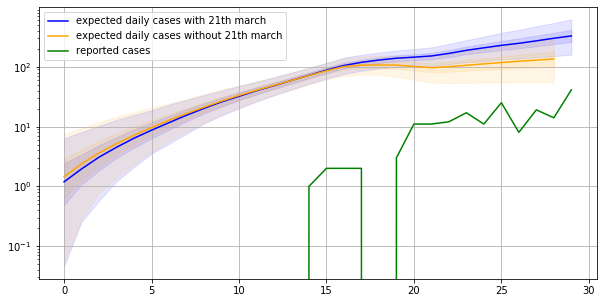

In [28]:
def plot_trace(trace, key, label, color, error_bands=True):
    plt.plot(np.median(trace[key], axis=0), label=label, color=color)
    if error_bands:
        plt.fill_between(np.arange(trace[key].shape[1]), np.percentile(trace[key], 2.5, axis=0), np.percentile(trace[key], 97.5, axis=0), alpha=0.1,  color=color)
        plt.fill_between(np.arange(trace[key].shape[1]), np.percentile(trace[key], 25, axis=0), np.percentile(trace[key], 75, axis=0), alpha=0.1,  color=color)
    

old_trace = old_results[(8, 8, 8, 4, (0,0,0,0,1,2,3,3,3,3,3,3,3,2,1))]
trace = new_results[(8, 8, 8, 4, (0,0,0,0,1,2,3,3,3,3,3,3,3,2,1))]
plot_trace(trace, "daily", label="expected daily cases with 21th march", color="blue")
plot_trace(old_trace, "daily", label="expected daily cases without 21th march", color="orange")
plt.plot((SK_CASES_BY_DAY), label="reported cases", color="green")
plt.yscale("log")
plt.legend()
plt.grid()

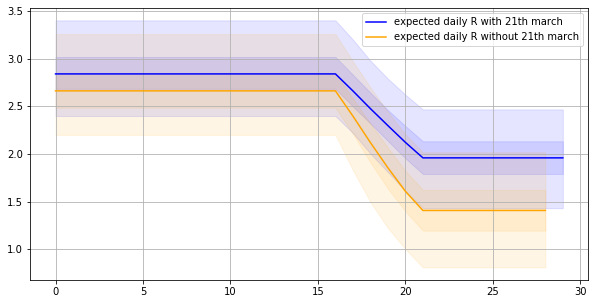

In [11]:
old_trace = old_results[(8, 8, 8, 4, (0,0,0,0,1,2,3,3,3,3,3,3,3,2,1))]
trace = new_results[(8, 8, 8, 4, (0,0,0,0,1,2,3,3,3,3,3,3,3,2,1))]
plot_trace(trace, "R", label="expected daily R with 21th march", color="blue")
plot_trace(old_trace, "R", label="expected daily R without 21th march", color="orange")
plt.legend()
plt.grid()

In [20]:
colors = list(mcolors.TABLEAU_COLORS.keys())
colors[0]

'tab:blue'

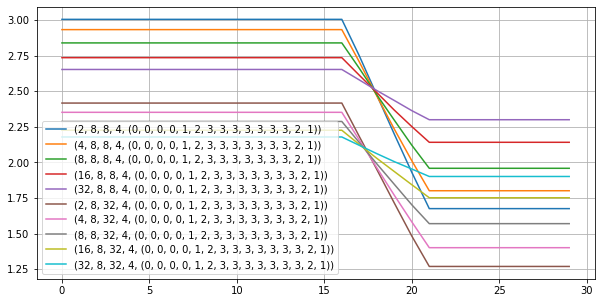

In [39]:
for i, (x, trace) in enumerate(new_results.items()):
    plot_trace(trace, "R", label=str(x), color=colors[i], error_bands=False)
plt.grid(True)
plt.legend()

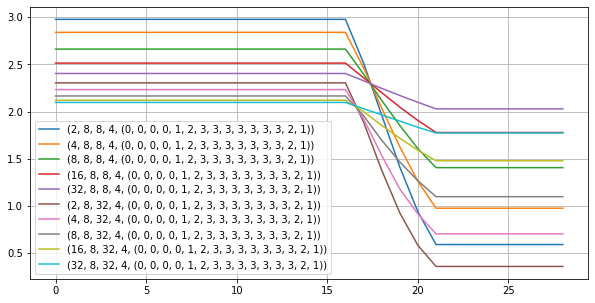

In [40]:
for i, (x, trace) in enumerate(old_results.items()):
    plot_trace(trace, "R", label=str(x), color=colors[i], error_bands=False)
plt.grid(True)
plt.legend()

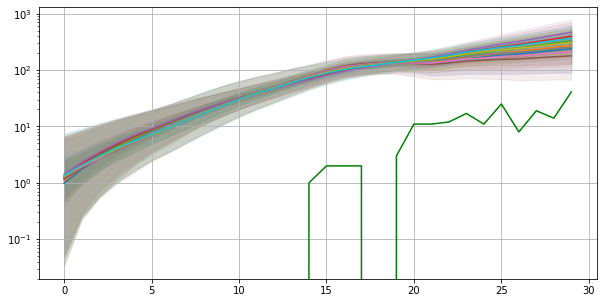

In [45]:
for i, (x, trace) in enumerate(new_results.items()):
    plot_trace(trace, "daily", label=str(x), color=colors[i], error_bands=True)
plt.grid(True)
plt.plot((SK_CASES_BY_DAY), label="reported cases", color="green")
plt.yscale("log")

In [33]:
all_Rs = np.vstack([trace["R"] for trace in new_results.values()])
all_Rs.shape

(80000, 30)

In [36]:
# starting R
np.percentile(all_Rs, 2.5, axis=0)[0], np.percentile(all_Rs, 25, axis=0)[0], np.percentile(all_Rs, 50, axis=0)[0], np.percentile(all_Rs, 75, axis=0)[0], np.percentile(all_Rs, 97.5, axis=0)[0]

(2.0300820575091425,
 2.2755321134114865,
 2.5708000827806514,
 2.8503756524027986,
 3.370336422790551)

In [37]:
# final R
np.percentile(all_Rs, 2.5, axis=0)[-1], np.percentile(all_Rs, 25, axis=0)[-1], np.percentile(all_Rs, 50, axis=0)[-1], np.percentile(all_Rs, 75, axis=0)[-1], np.percentile(all_Rs, 97.5, axis=0)[-1]

(0.9426619151307546,
 1.5127087152565664,
 1.7954417209793938,
 2.056353660719748,
 2.4925114235389736)